In [4]:
import Zip
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import math
import pickle

# Channels in the detector
det_ch = { 'tpc': list(range(0, 247+1)), 'veto': list(range(248, 253+1)), 
          'sum_wv': [254], 'busy_on': [255], 'busy_off': [256],
          'hev_on': [257], 'hev_off': [258], 'muon_veto_trigger': [259], } 
n_channels = 260

# for reading the ini file
from configparser import ConfigParser, ExtendedInterpolation
config = ConfigParser(inline_comment_prefixes='#', interpolation=ExtendedInterpolation(), strict=True)
config.optionsxform = str
config.read('xenon1t.ini')
gain = eval(config['DEFAULT']['gains'])

# Initial parameters
baseline_ = 16382. * np.ones(n_channels)
std_ = 2.3 * np.ones(n_channels)

# The data files
NG = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/NG") # Neutron data
Rn220 = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/Rn220") # Rn-220 data

In [65]:
ch_top = eval(config['DEFAULT']['channels_top'])

def Waveform_change(raw,eventnr):
    event = raw.get_single_event(eventnr)
    #ch_top = eval(config['DEFAULT']['channels_top'])
                                
    #The variables that check if a channel is the minimum channel
    adcmin_top = 16382
    adcmin_low = 16382
    minch_top = 0
    minch_low = 0
    
    
    n = 350000  
    for p in event.pulses:
        ch = p.channel
        #i = np.zeros(n_channels, dtype = int)
            #print(p.channel, ": ", p.left, p.right-p.left)
        wave = np.asarray(p.raw_data)
        adc_ch = 16382
        if gain[ch]!=0:
            wave_corrected = 16382 - (16382 - wave)/gain[ch]*4911399
            adc_ch = np.amin(wave_corrected)
            
        
                #Append all significant main channels to the list
            #if adc_corrected < 15000 and ch not in channellist and ch in det_ch['tpc']:
                #channellist.append(ch)
                
                #Check which channel is the minimum channel
        if ch in ch_top:
            if adc_ch < adcmin_top:
                adcmin_top = adc_ch
                minch_top = ch
        elif ch in det_ch['tpc'] and adc_ch < adcmin_low:
            adcmin_low = adc_ch
            minch_low = ch
                
    #Sort for convenience
    #channellist.sort()
    return minch_top, minch_low

In [67]:
try_minchannel = Waveform_change(NG,300)
print(try_minchannel)

(110, 200)


In [42]:
print(try_minchannel)

154


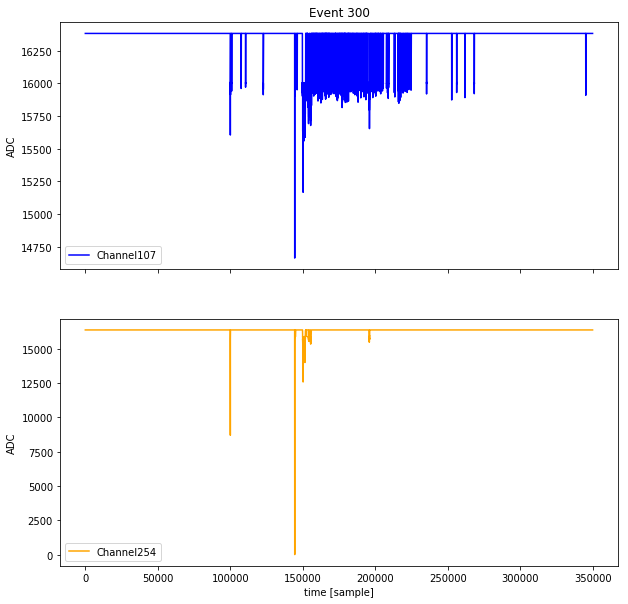

In [25]:
#Select two channels to compare
channel1 = 107
channel2 = 254

#Plot the two channels
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 10) # can't be in same cell as import matplotlib 
figs, ax = plt.subplots(2, 1, sharex='col')
ax[0].plot(try_t, try_ts[channel1], label='Channel' + str(channel1), color = 'blue')
ax[1].plot(try_t, try_ts[channel2], label='Channel' + str(channel2), color='orange')
ax[0].set_ylabel("ADC")
ax[1].set_ylabel("ADC")
ax[1].set_xlabel("time [sample]")
ax[0].set_title('Event ' + str(300))
ax[0].legend()
ax[1].legend()
#ax[0].set_xlim(90000,120000)
#ax[1].set_xlim(90000,120000)

In [91]:
def minchannel(file, n):
    start_time = time.time()
    minchannel_list = []
    for i in range(n):
        if i%100 == 0:
            print(i, time.time()-start_time)
        try_minchannel = Waveform_change(file,i)
        minchannel_list.append(try_minchannel)
    return (minchannel_list)
        

In [69]:
NG_minchannels = minchannel(NG, 10000)

0 3.337860107421875e-06
100 20.642680406570435
200 39.40732717514038
300 66.02537250518799
400 89.97321939468384
500 125.83472967147827
600 158.09881043434143
700 189.72837495803833
800 221.1412124633789
900 255.39059495925903
1000 288.7696976661682
1100 319.2355992794037
1200 358.0311818122864
1300 392.8723168373108
1400 430.4194846153259
1500 459.1321368217468
1600 494.2335650920868
1700 532.8430721759796
1800 567.4361357688904
1900 602.2290639877319
2000 633.9384665489197
2100 668.5742378234863
2200 698.5147259235382
2300 734.9941604137421
2400 768.3815960884094
2500 805.8968455791473
2600 841.8433454036713
2700 874.1520621776581
2800 903.9994125366211
2900 946.4313144683838
3000 982.5449192523956
3100 1021.1346304416656
3200 1054.9114365577698
3300 1090.8502101898193
3400 1127.3450334072113
3500 1163.3355207443237
3600 1194.6080672740936
3700 1229.8455634117126
3800 1262.879323720932
3900 1298.1608786582947
4000 1329.613784313202
4100 1362.7041816711426
4200 1397.8078320026398
4300

In [70]:
with open('NG_minchannels.p', 'wb') as fp:
    pickle.dump(NG_minchannels, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [79]:
print(len(NG_minchannels))

10000


In [82]:
min10000 = Waveform_change(NG,10000)
NG_minchannels.append(min10000)

In [83]:
with open('NG_minchannels.p', 'wb') as fp:
    pickle.dump(NG_minchannels, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [71]:
def Peaks(pulse, printall):
    
    
    # The standard variables
    q = 0
    left_t, right_t = 0, 0
    baseline = 16382.
    std = 2.3
    ch = pulse.channel
    wave = pulse.raw_data
    
    # The index for the minimum
    minindex = len(wave)
    
    # Variables for the average, the ratio and the slope
    avfound = 0
    samplelist = [wave[0]]
    ratio = 1
    slope = 0
    sw = 0

    s = np.std(wave)
    delta = baseline - np.min(wave)
    if min(s, delta) > 5*std:
        for samples in enumerate(wave):
            base_sub = samples[1] - baseline
            if abs(base_sub) > 5*std:
                q = q + base_sub
            
            # Compute the average of the previous samples
            av = np.average(samplelist)
            
            # left_t is assigned when a significant deviation from the average is recorded
            if abs(samples[1] - av) > 20 and left_t == 0:
                left_t = samples[0]
                
                # The sample value at left_t is kept for the slope calculation
                leftsample = samplelist[-1]
                if printall:
                    print("left_t here")
                avfound = av
             
            # Find the index for the minimum
            if samples[1] == np.min(wave):
                minindex = samples[0]

            # right_t is assigned in a similar way as left_t
            if abs(samples[1] - avfound) < 20 and samples[0] > minindex and right_t == 0: 
                right_t = samples[0]
                if printall:
                    print("right_t here")
                
            # Add the current sample to the sample list
            samplelist.append(samples[1])
            
            # A printing section in case the raw data needs to be analysed
            if printall:
                print(samples)
                print("Average:", av)
                if left_t == 0:
                    print("Average difference:", abs(samples[1] - av))
                else:
                    print("Average difference:", abs(samples[1] - avfound))
                print()
        
        # Calculate the ratio and the slope
        ratio = np.min(wave)/int(avfound)
        delta_x = minindex - left_t
        if delta_x != 0:
            slope = (np.min(wave) - leftsample)/delta_x
        
    else:
        baseline = np.average(wave)
        std = s
    width = right_t - left_t
    if width != 0:
        sw = slope/width
        if -q/width < 3*std or ratio >= 0.99:
            q = 0
    return (ch, q, width, pulse.left+left_t, sw)

In [84]:
def s1s2_info(file, minchannel_list, n):
    info_list = []
    #width_list = []
    #sw_list = []

    start_time = time.time()

    for event in file.get_events():
        eventnr = event.event_number
        minchannel = minchannel_list[eventnr]
        if eventnr%100 == 0:
            print(eventnr, time.time()-start_time)
    
        s1_q = 0
        s1_t0 = 0
        s2_q = 0
        s2_t0 = 0
    
        s1_channellist = []
        s2_channellist = []
    
        s1_checker = 1
        s2_checker = 1
    
        for p in event.pulses:
            if p.channel == minchannel[0]:
                (ch, q, width, t0, sw) = Peaks(p, False)
                if gain[ch]!=0:
                    q = q/gain[ch]*4911399
                if q < 0 and sw != 0:
                    sw = -sw
                    if sw < 2:
                        if s2_q == 0:
                            s2_t0 = t0
                        s2_q = s2_q - q
            if p.channel == minchannel[1]:
                (ch, q, width, t0, sw) = Peaks(p, False)
                if gain[ch]!=0:
                    q = q/gain[ch]*4911399
                if q < 0 and sw != 0:
                    sw = -sw
                    if sw > 2:
                        if s1_q == 0:
                            s1_t0 = t0
                            s1_q = -q
            else:
                if s1_checker<3 or s2_checker<4:
                    (ch, q, width, t0, sw) = Peaks(p, False)
                    if q<0 and sw!=0:
                        sw = -sw
                        if sw > 2 and ch not in s1_channellist:
                            s1_channellist.append(ch)
                            s1_checker += 1
                        if sw < 2 and ch not in s2_channellist:
                            s2_channellist.append(ch)
                            s2_checker += 1
                    
        if s1_q and s2_q and s1_checker>2 and s2_checker>3:
            info = {'event': event.event_number, 's1': s1_q, 's2': s2_q,
                    's1_position': s1_t0, 's2_position': s2_t0}
            info_list.append(info)
        if event.event_number == n-1:
            break

    
    return(info_list)
    

In [85]:
info_NG = s1s2_info(NG, NG_minchannels, 10000)

0 0.08030915260314941
100 133.34212446212769
200 1817.4124615192413
300 1973.253394126892
400 2174.896819114685
500 2501.2623369693756
600 2779.4491107463837
700 3043.041308403015
800 3272.50523853302
900 3548.56694316864
1000 3826.632267475128
1100 4100.534084558487
1200 4388.093163251877
1300 4650.118121385574
1400 5143.251553297043
1500 5406.636764526367
1600 5721.609267234802
1700 6050.899568319321
1800 6337.055135965347
1900 6597.001640796661
2000 6831.943020820618
2100 7094.325985431671
2200 7365.548172950745
2300 7670.736186504364
2400 7987.610023021698
2500 8300.101241827011
2600 8551.643053293228
2700 8928.58129787445
2800 9229.884251594543
2900 9607.753477573395
3000 9879.961649179459
3100 10379.705168008804
3200 10661.328260183334
3300 10963.824759244919
3400 11328.09914135933
3500 11634.217779397964
3600 11927.176473855972
3700 12194.093760728836
3800 12463.295432567596
3900 12721.302960157394
4000 13069.015421390533
4100 13299.833831071854
4200 13615.176577806473
4300 1391

In [86]:
print(len(info_NG))

7785


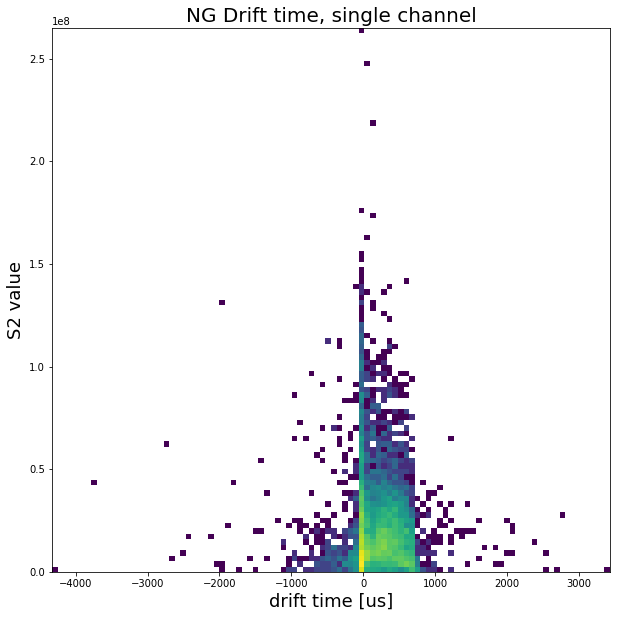

In [88]:
# Drift time
#%matplotlib inline
s1 = []
s2 = []
drift = []
for info in info_NG:
    drift.append(1e-2*(info['s2_position']-info['s1_position']))
    s1.append(info['s1'])
    s2.append(info['s2'])
fig2, ax2 = plt.subplots(figsize = (10.,10.))
ax2.hist2d(drift, s2, bins=(100,100), norm=mpl.colors.LogNorm())
ax2.set_xlabel("drift time [us]", fontsize = 18)
ax2.set_ylabel('S2 value', fontsize = 18)
ax2.set_title('NG Drift time, single channel', fontsize = 20)
#ax2.set_xlim(0., 200000)
fig2.savefig('NG_drift_single.png', dpi = 300)
plt.show()

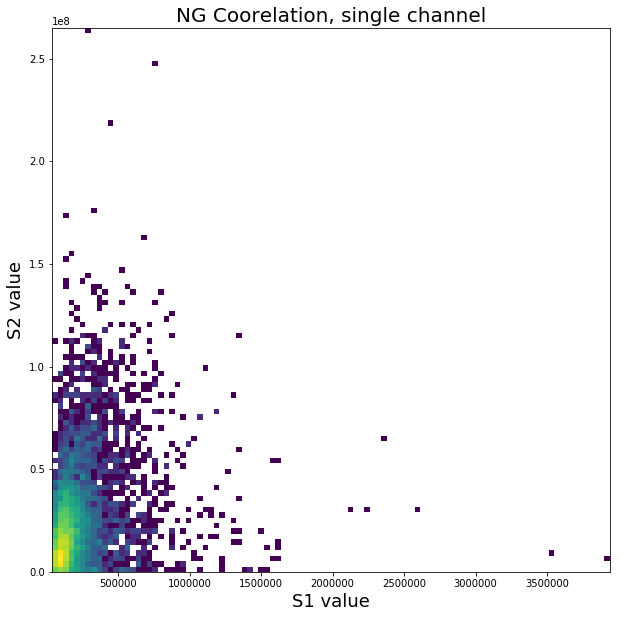

In [89]:
fig3, ax3 = plt.subplots(figsize = (10.,10.))
ax3.hist2d(s1, s2, bins=(100,100), norm=mpl.colors.LogNorm())
ax3.set_xlabel('S1 value', fontsize = 18)
ax3.set_ylabel('S2 value', fontsize = 18)
ax3.set_title('NG Coorelation, single channel', fontsize = 20)
#ax3.set_xlim(0., 200000)
fig3.savefig('NG_s1s2_single.png', dpi = 300)
plt.show()

In [90]:
with open('NG_data_single.p', 'wb') as fp:
    pickle.dump(info_NG, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [94]:
Rn220_minchannels = minchannel(Rn220, 10000)

0 3.814697265625e-06
100 20.14352774620056
200 32.480525732040405
300 43.915865659713745
400 56.07768797874451
500 65.98197817802429
600 79.62221956253052
700 89.92355060577393
800 107.02116227149963
900 122.13075256347656
1000 130.95948719978333
1100 144.75736141204834
1200 161.91324949264526
1300 173.7464554309845
1400 185.95733165740967
1500 199.60070180892944
1600 211.26187872886658
1700 221.87265419960022
1800 232.38557887077332
1900 245.17284417152405
2000 258.66875076293945
2100 273.2378885746002
2200 286.45076751708984
2300 301.4297652244568
2400 314.4626889228821
2500 328.0714604854584
2600 342.6355438232422
2700 354.91659474372864
2800 367.8936529159546
2900 380.673752784729
3000 391.33007884025574
3100 404.10786652565
3200 416.06556224823
3300 428.74437403678894
3400 441.1586718559265
3500 451.9061119556427
3600 469.5410816669464
3700 483.2771484851837
3800 495.4495449066162
3900 510.0391275882721
4000 523.2594213485718
4100 535.9708123207092
4200 548.6189703941345
4300 560.

In [95]:
print(len(Rn220_minchannels))

10000


In [96]:
info_Rn220 = s1s2_info(Rn220, Rn220_minchannels, 9999)

0 0.021773815155029297
100 158.35755372047424
200 274.02085161209106
300 398.9163646697998
400 501.2321219444275
500 594.6851058006287
600 717.102002620697
700 827.2529330253601
800 962.9375717639923
900 1104.4530832767487
1000 1188.6681175231934
1100 1309.1126782894135
1200 1453.012840270996
1300 1546.7618434429169
1400 1661.8375096321106
1500 1789.224279642105
1600 1894.1343455314636
1700 2019.8359620571136
1800 2113.150478363037
1900 2235.664384126663
2000 2354.9379091262817
2100 2483.2473962306976
2200 3634.99414563179
2300 3765.7180967330933
2400 3876.37362575531
2500 3994.690908432007
2600 4110.457603216171
2700 4215.466657161713
2800 4339.897924423218
2900 4466.016718387604
3000 4576.060417175293
3100 4690.0883984565735
3200 4802.316281318665
3300 4926.099643468857
3400 5033.567514181137
3500 5136.621716499329
3600 5298.548001289368
3700 5417.769325494766
3800 5524.646341085434
3900 5638.455381393433
4000 5745.292502641678
4100 5866.135048866272
4200 5977.12854719162
4300 6082.7

In [97]:
print(len(info_Rn220))

5807


In [98]:
with open('Rn220_data_single.p', 'wb') as fp:
    pickle.dump(info_Rn220, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('Rn220_dat_single.p', 'wb') as fp:
    pickle.dump(info_Rn220, fp, protocol=pickle.HIGHEST_PROTOCOL)
Rn220_minchannels